In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from elofooot import EloRating
from h2h_features import add_h2h_features



#charger le fichier si present si pas present le creer :
try :
    liga1 =pd.read_csv("C:/Users/USER/Documents/projet&code/datasets/football/liga1/liga1824.csv")
except FileNotFoundError :
    fichiers = {
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12018.csv": "2018/2019",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12019.csv": "2019/2020",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12020.csv": "2020/2021",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12021.csv": "2021/2022",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12022.csv": "2022/2023",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12023.csv": "2023/2024",
        "C:/Users/USER/Documents/projet&code/datasets/football/liga1/SP12024.csv": "2024/2025",
    }

    # Liste pour stocker les DataFrames
    dfs = []

    # Charger les fichiers un par un
    for fichier, saison in fichiers.items():
        df = pd.read_csv(fichier)
        df["Saison"] = saison  # Ajouter la saison dans une nouvelle colonne
        dfs.append(df)

    # Fusionner tous les DataFrames en un seul
    liga1 = pd.concat(dfs, ignore_index=True)
    #creer le fichier
    liga1.to_csv("C:/Users/USER/Documents/projet&code/datasets/football/liga1/liga1824.csv", index=False)




(1158, 44)
Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY',
       'HR', 'AR', 'B365H', 'B365D', 'B365A', 'elo_home', 'elo_away',
       'diff_elo', 'H2H_matches', 'H2H_avg_goals_home', 'H2H_home_win_rate',
       'HS_avg', 'AS_avg', 'FTHG_avg', 'FTAG_avg', 'HST_avg', 'AST_avg',
       'HC_avg', 'AC_avg', 'HF_avg', 'AF_avg', 'HY_avg', 'AY_avg', 'HR_avg',
       'AR_avg'],
      dtype='object')


In [2]:
colonnes_utiles = [
    'Date','HomeTeam','AwayTeam',
    'FTHG','FTAG','FTR',
    'HTHG','HTAG','HTR',
    'HS','AS','HST','AST',
    'HF','AF','HC','AC',
    'HY','AY','HR','AR','B365H','B365D','B365A'
]


In [3]:
#enlever les lignes inutiles
liga1= liga1[colonnes_utiles]
print(liga1.shape)
#gerer la date en int
##
liga1['Date'] = pd.to_datetime(liga1['Date'])
liga1['Month'] = liga1['Date'].dt.month
liga1['Day'] = liga1['Date'].dt.day
liga1['Year'] = liga1['Date'].dt.year
# First, ensure 'Year', 'Month', and 'Day' are integers
liga1[['Year', 'Month', 'Day']] = liga1[['Year', 'Month', 'Day']].astype(int)
liga1['Date'] = liga1['Year'] * 10000 + liga1['Month'] * 100 + liga1['Day']
liga1=liga1.sort_values('Date') # sort les values de la date
# Drop the the table less unused :
liga1=liga1.drop(columns=['Day','Month', 'Year'])
print(liga1)

(1158, 24)
          Date    HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  HS  \
1144  19700101     Sevilla   Villarreal     1     1   D     0     0   D  18   
1145  19700101      Getafe     Valencia     1     0   H     0     0   D   8   
1146  19700101     Sevilla     Sociedad     5     2   H     1     1   D  22   
1147  19700101     Osasuna  Real Madrid     1     4   A     1     2   A  14   
1148  19700101  Ath Madrid      Levante     1     0   H     0     0   D  19   
...        ...         ...          ...   ...   ...  ..   ...   ...  ..  ..   
1154  19700101  Ath Madrid        Eibar     5     0   H     2     0   H  10   
1155  19700101    Sociedad      Sevilla     1     2   A     1     2   A   5   
1156  19700101    Valencia   Villarreal     3     0   H     1     0   H  18   
1157  19700101       Elche      Sevilla     2     1   H     0     0   D   6   
0     19700101       Celta     Sociedad     0     1   A     0     1   A   6   

      ...  AF  HC  AC  HY  AY  HR  AR  B

In [4]:
#initialisation de l'elo
elo = EloRating()
# Colonnes à remplir
elo_home = []
elo_away = []
for _, row in liga1.iterrows():
    home = row['HomeTeam']
    away = row['AwayTeam']
    result = row['FTR']  # "H", "A", "D"

    # Obtenir rating AVANT match
    elo_home.append(elo.get_rating(home))
    elo_away.append(elo.get_rating(away))

    # Mettre à jour le score ELO selon résultat
    elo.update_ratings(home, away, result)

# Ajouter les colonnes ELO
liga1['elo_home'] = elo_home
liga1['elo_away'] = elo_away
liga1['diff_elo'] = liga1['elo_home'] - liga1['elo_away']
#ajout du head to head
liga1 = add_h2h_features(liga1)

creer les collonnes des données que l'on va utiliser pour predire dans le dataset(moyenne glissante, moyenne des tirs cadré des 3 dernier match, tir cadré du dernier match, moyenne de corner, moyenne de carton jaune, ect ect)

In [5]:

def addstat(): #ajouter les statistiques interessantes pour l'apprentisage 
    #creer les moyennes glissantes pour pouvoir analyser les performances passées
    # Moyenne des tirs pour équipe à domicile
    liga1['HS_avg'] = liga1.groupby('HomeTeam')['HS'].transform(lambda x: x.shift(1).rolling(4).mean())
    # Moyenne des tirs pour équipe à l'extérieur
    liga1['AS_avg'] = liga1.groupby('AwayTeam')['AS'].transform(lambda x: x.shift(1).rolling(4).mean())
    #moyenne des buts
    liga1['FTHG_avg'] = liga1.groupby('HomeTeam')['FTHG'].transform(lambda x: x.shift(1).rolling(4).mean())
    # Moyenne des tirs pour équipe à l'extérieur
    liga1['FTAG_avg'] = liga1.groupby('AwayTeam')['FTAG'].transform(lambda x: x.shift(1).rolling(4).mean())
    liga1['HST_avg'] = liga1.groupby('HomeTeam')['HST'].transform(lambda x: x.shift(1).rolling(4).mean())
    # Moyenne des tirs cibles pour équipe à l'extérieur
    liga1['AST_avg'] = liga1.groupby('AwayTeam')['AST'].transform(lambda x: x.shift(1).rolling(4).mean())
    #moyenne des buts à  domicile
    # Moyenne des corners pour équipe à domicile
    liga1['HC_avg'] = liga1.groupby('HomeTeam')['HC'].transform(lambda x: x.shift(1).rolling(4).mean())
    # Moyenne des corners pour équipe à l'extérieur
    liga1['AC_avg'] = liga1.groupby('AwayTeam')['AC'].transform(lambda x: x.shift(1).rolling(4).mean())

    # Moyenne des fautes pour équipe à domicile
    liga1['HF_avg'] = liga1.groupby('HomeTeam')['HF'].transform(lambda x: x.shift(1).rolling(4).mean())
    # Moyenne des fautes pour équipe à l'extérieur
    liga1['AF_avg'] = liga1.groupby('AwayTeam')['AF'].transform(lambda x: x.shift(1).rolling(4).mean())

    # Moyenne des cartons jaunes pour équipe à domicile
    liga1['HY_avg'] = liga1.groupby('HomeTeam')['HY'].transform(lambda x: x.shift(1).rolling(4).mean())
    # Moyenne des cartons jaunes pour équipe à l'extérieur
    liga1['AY_avg'] = liga1.groupby('AwayTeam')['AY'].transform(lambda x: x.shift(1).rolling(4).mean())

    # Moyenne des cartons rouges pour équipe à domicile
    liga1['HR_avg'] = liga1.groupby('HomeTeam')['HR'].transform(lambda x: x.shift(1).rolling(4).mean())
    # Moyenne des cartons rouges pour équipe à l'extérieur
    liga1['AR_avg'] = liga1.groupby('AwayTeam')['AR'].transform(lambda x: x.shift(1).rolling(4).mean())
    #bilan des 5 derniers match
    
addstat()
adropna = ["HS_avg", "AS_avg", "FTHG_avg", "FTAG_avg", "HST_avg", "AST_avg", "HC_avg", "AC_avg", "HF_avg", "AF_avg",
"HY_avg", "AY_avg", "HR_avg", "AR_avg"]
print(liga1)


                              Date    HomeTeam     AwayTeam  FTHG  FTAG FTR  \
1144 1970-01-01 00:00:00.019700101     Sevilla   Villarreal     1     1   D   
799  1970-01-01 00:00:00.019700101      Girona      Osasuna     2     0   H   
798  1970-01-01 00:00:00.019700101   Barcelona        Celta     3     2   H   
797  1970-01-01 00:00:00.019700101       Celta        Betis     0     0   D   
796  1970-01-01 00:00:00.019700101     Espanol   Villarreal     1     2   A   
...                            ...         ...          ...   ...   ...  ..   
359  1970-01-01 00:00:00.019700101      Girona   Ath Madrid     1     1   D   
358  1970-01-01 00:00:00.019700101       Cadiz       Getafe     1     0   H   
357  1970-01-01 00:00:00.019700101  Ath Madrid        Celta     1     0   H   
425  1970-01-01 00:00:00.019700101  Villarreal  Real Madrid     0     0   D   
0    1970-01-01 00:00:00.019700101       Celta     Sociedad     0     1   A   

      HTHG  HTAG HTR  HS  ...  HST_avg  AST_avg  HC

In [6]:
# netoyage des donnes
liga1["HST"] = liga1["HST"].fillna(0)
liga1["AST"] = liga1["AST"].fillna(0)
liga1["HF"] = liga1["HF"].fillna(0)
liga1["AF"] = liga1["AF"].fillna(0)
liga1 =liga1.dropna(subset=adropna)
print(liga1)

# Supprimer les lignes sans issue de match (FTR)
liga1 = liga1.dropna(subset=["FTR"])
print(liga1.head(3))
print(liga1.shape)
print(liga1.columns)


print(liga1.head(3))
print(liga1.shape)
print(liga1.columns)

                             Date     HomeTeam     AwayTeam  FTHG  FTAG FTR  \
709 1970-01-01 00:00:00.019700101      Osasuna        Betis     1     2   A   
753 1970-01-01 00:00:00.019700101      Osasuna       Alaves     1     0   H   
758 1970-01-01 00:00:00.019700101    Barcelona        Cadiz     2     0   H   
863 1970-01-01 00:00:00.019700101      Osasuna   Ath Madrid     0     5   A   
862 1970-01-01 00:00:00.019700101  Real Madrid   Ath Madrid     1     0   H   
..                            ...          ...          ...   ...   ...  ..   
359 1970-01-01 00:00:00.019700101       Girona   Ath Madrid     1     1   D   
358 1970-01-01 00:00:00.019700101        Cadiz       Getafe     1     0   H   
357 1970-01-01 00:00:00.019700101   Ath Madrid        Celta     1     0   H   
425 1970-01-01 00:00:00.019700101   Villarreal  Real Madrid     0     0   D   
0   1970-01-01 00:00:00.019700101        Celta     Sociedad     0     1   A   

     HTHG  HTAG HTR  HS  ...  HST_avg  AST_avg  HC_

In [7]:
liga1.to_csv("C:/Users/USER/Documents/projet&code/datasets/football/liga1/liga1824.csv", index=False)
#Save the file

encodage 

In [8]:
liga1 = pd.get_dummies(liga1, columns=["HomeTeam", "AwayTeam"], drop_first=True)
colladrop =["HS", "AS", "HST", "AST", "HHW", "AHW", "HC", "AC", "HF", "AF", "HY", "AY", "HR",
"AR", "FTR","HTR","FTAG", "HTAG", "FTHG", "HTHG", "Date"]
# Définir X et y
y = liga1["FTR"].map({"H": 0, "D": 1, "A": 2})  # cible
X = liga1.drop(columns=colladrop, errors="ignore")  # variables d'entrée

pca


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_components = 30
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train)


apprentisage

In [16]:


model_pca = RandomForestClassifier(n_estimators=500, random_state=42)

   # Fit the model on the reduced training data
model_pca.fit(X_train_reduced, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [17]:
# #evaluer le modele
X_test_reduced = pca.transform(X_test)
y_pred_pca = model_pca.predict(X_test_reduced)

print("Accuracy with pca :", accuracy_score(y_test, y_pred_pca))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_pca))
print("Rapport de classification :")
print(classification_report(y_test, y_pred_pca))


Accuracy with pca : 0.5048543689320388
Matrice de confusion :
[[73  4  7]
 [41  6  9]
 [31 10 25]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.50      0.87      0.64        84
           1       0.30      0.11      0.16        56
           2       0.61      0.38      0.47        66

    accuracy                           0.50       206
   macro avg       0.47      0.45      0.42       206
weighted avg       0.48      0.50      0.45       206



In [18]:
importances = model_pca.feature_importances_
feature_names = ['PC' + str(i+1) for i in range(n_components)]
sorted_indices = importances.argsort()
sorted_feature_importance = [(feature_names[i], importances[i]) for i in range(len(feature_names))]
sorted_feature_importance.sort(key=lambda x: x[1], reverse=True)
for feature, score in sorted_feature_importance:
       print(f"{feature}: {score}")


PC1: 0.07267350590245353
PC10: 0.043818670407814286
PC4: 0.03672000627528339
PC27: 0.03643028660320258
PC3: 0.03509729696831573
PC28: 0.034932131807606855
PC5: 0.03394371549050751
PC6: 0.033599583779025534
PC8: 0.03320274976527387
PC16: 0.033188117586699394
PC7: 0.032388372028135236
PC26: 0.03237050530098779
PC24: 0.03190745631644459
PC18: 0.03132595284185085
PC17: 0.031247741870262618
PC11: 0.03094267790549637
PC21: 0.030879919126975505
PC23: 0.030866309030826756
PC14: 0.030759768174433644
PC15: 0.03074273544944338
PC30: 0.030381218506546445
PC2: 0.03018794687032849
PC9: 0.030054726552473227
PC29: 0.03001537004210334
PC22: 0.029972699784438134
PC25: 0.029864788910058445
PC13: 0.028626571042534976
PC12: 0.028410513148518505
PC19: 0.028205363347596105
PC20: 0.027243299164362942


plot importance

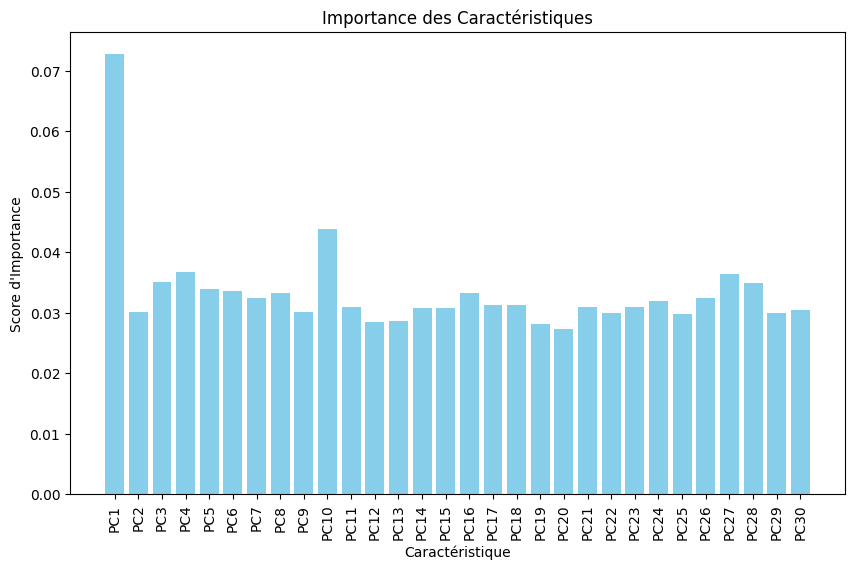

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Importance des Caractéristiques")
plt.bar(range(len(feature_names)), importances, align="center", color="#87CEEB", label="Importance")
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.xlabel("Caractéristique")
plt.ylabel("Score d'Importance")
plt.show()

In [20]:
loadings = pca.components_.shape
# Obtenir les noms d'origine des colonnes
original_features = X.columns

# Créer un DataFrame pour visualiser les poids de chaque feature sur chaque composante
pca_df = pd.DataFrame(pca.components_, columns=original_features, index=feature_names)
print("Top features dans la composante PC19 :")
print(pca_df.loc["PC2"].sort_values(key=abs, ascending=False).head(5))
print("Top features dans la composante PC12 :")
print(pca_df.loc["PC7"].sort_values(key=abs, ascending=False).head(5))
print("Top features dans la composante PC11 :")
print(pca_df.loc["PC11"].sort_values(key=abs, ascending=False).head(5))
print("Top features dans la composante PC17(la plus basse) :")
print(pca_df.loc["PC1"].sort_values(key=abs, ascending=False).head(5))

Top features dans la composante PC19 :
elo_home    0.707534
elo_away    0.706519
HS_avg      0.008101
AS_avg      0.005416
HF_avg     -0.005405
Name: PC2, dtype: float64
Top features dans la composante PC12 :
HF_avg     0.911856
HS_avg     0.331363
HY_avg     0.145052
HST_avg    0.119062
AS_avg    -0.114353
Name: PC7, dtype: float64
Top features dans la composante PC11 :
HST_avg     0.773525
FTHG_avg    0.405911
HS_avg     -0.335060
B365H       0.224605
HC_avg      0.150835
Name: PC11, dtype: float64
Top features dans la composante PC17(la plus basse) :
diff_elo    0.816432
elo_away   -0.409138
elo_home    0.407295
B365A       0.008725
HS_avg      0.004496
Name: PC1, dtype: float64
